In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# OSMNX

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

import geopandas as gpd
from shapely import geometry
import osmnx as ox
import geopandas as gpd
import os

from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder

training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [3]:
if manual:
    %matplotlib inline
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

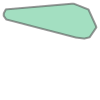

In [4]:
zones = gpd.read_file(r'../../inputs/zones/zones_name_and_sample.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).convex_hull.buffer(1e-3)
hull

# OSMNX API

In [5]:
drive = ox.graph_from_polygon(hull, network_type='all_private')

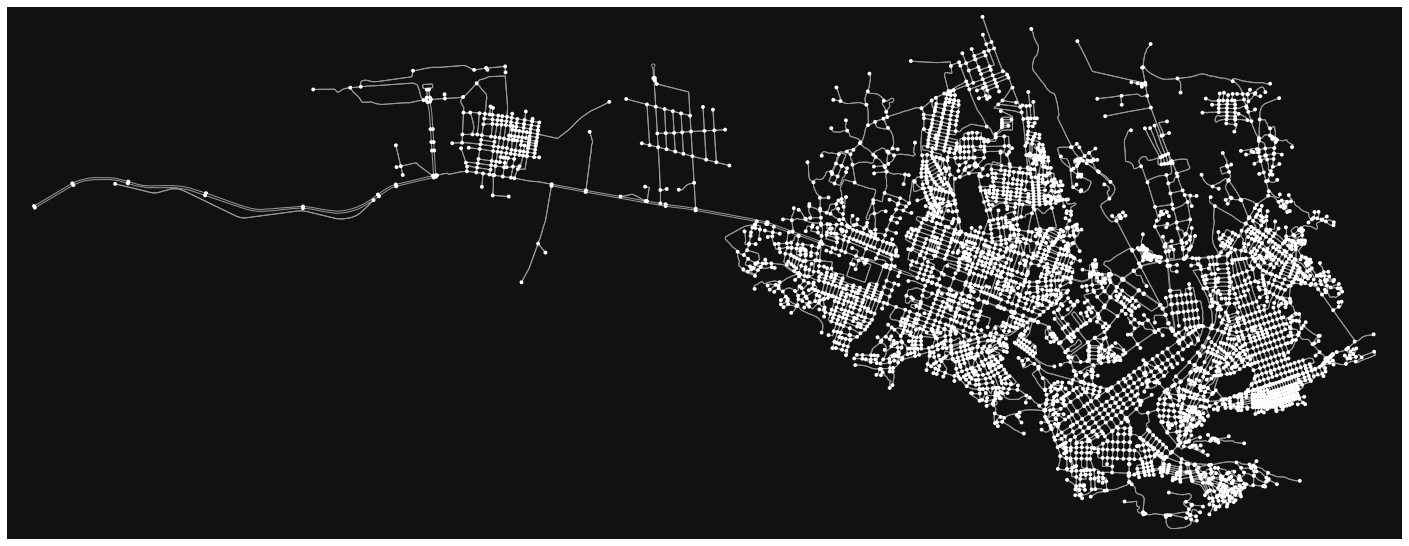

In [6]:
plot = ox.plot_graph(drive, figsize=[25,  10])

In [7]:
road_nodes, road_links = ox.graph_to_gdfs(drive)
road_links.reset_index(drop=False, inplace=True)
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
try:
    road_nodes['osmid'] = road_nodes['osmid'].astype(str)
except KeyError:
    road_nodes['osmid'] = [str(i) for i in road_nodes.index]
    
road_nodes.index = 'osm_node_' + road_nodes['osmid'].astype(str)
road_nodes = road_nodes[['geometry']]

road_links[['from', 'to']] = 'osm_node_' + road_links[['from', 'to']].astype(str)

In [8]:
highway_order = [
    'motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential',
    'living_street', 'service', 'pedestrian', 'track', 'bus_guideway', 'escape', 'raceway', 'road',
    'footway', 'bridleway', 'steps', 'corridor', 'path',
    'motorway_link', 'trunk_link', 'primary_link', 'secondary_link', 'tertiary_link',
]

def highest_highway_order(value):
    if value in highway_order:
        return value
    
    for match in highway_order:
        if match in value: 
            return match
        
    return 'unknown'

road_links['highway'] = road_links['highway'].apply(highest_highway_order)
#irrelevant = ['pedestrian', 'footway', 'service', 'cycleway', 'residential']
#sm.road_links = sm.road_links.loc[~sm.road_links['highway'].isin(irrelevant)]

In [15]:
import json
def merged_reversed_geometries_dict(geojson_dict):
    features = {
        hash(tuple(tuple(p) for p in feature['geometry']['coordinates'])) :
        feature for feature in geojson_dict['features']
    }
    counts = {} # {geohash : 2 if the reverse geohash is in the geometries, 1 otherwise}
    drop = set() # for each direct/indirect geometry pair, countain the lesser geohash
    for _, feature in features.items():
        geo_tuple = tuple(tuple(p) for p in feature['geometry']['coordinates'])
        reversed_geo_tuple = reversed(geo_tuple)
        k = hash(tuple(geo_tuple))
        kr = hash(tuple(reversed_geo_tuple))
        drop.add(min(k, kr))
        counts[k] = counts.get(k, 0) + 1
        counts[kr] = counts.get(kr, 0) + 1
        if k == kr:
            print('hey')

    # keep only the feature with the higher geohash
    drop = {d for d in drop if counts[d] > 1}
    features = {k: v for k, v in features.items() if k not in drop}
    for k, v in features.items():
        v['properties']['oneway'] = int(counts[k] == 1) # 

    result = dict(geojson_dict)
    result['features'] = list(features.values())
    return result

def merge_reversed_geometries(geometries):
    try:
        return merged_reversed_geometries_dict(geometries)
    except KeyError: # 'features'
        geojson_dict = json.loads(geometries.to_json())
        temp = merged_reversed_geometries_dict(geojson_dict)
        return gpd.read_file(json.dumps(temp))
road_links = merge_reversed_geometries(road_links)

In [16]:
import shutil

road_links[['geometry', 'highway', 'oneway']].to_file(
    input_folder + 'roads/base.geojson', driver='GeoJSON')
shutil.copy(input_folder + 'roads/base.geojson', 
            input_folder + 'roads/ref_base.geojson')

'../../inputs/roads/ref_base.geojson'